In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
df.head(20)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


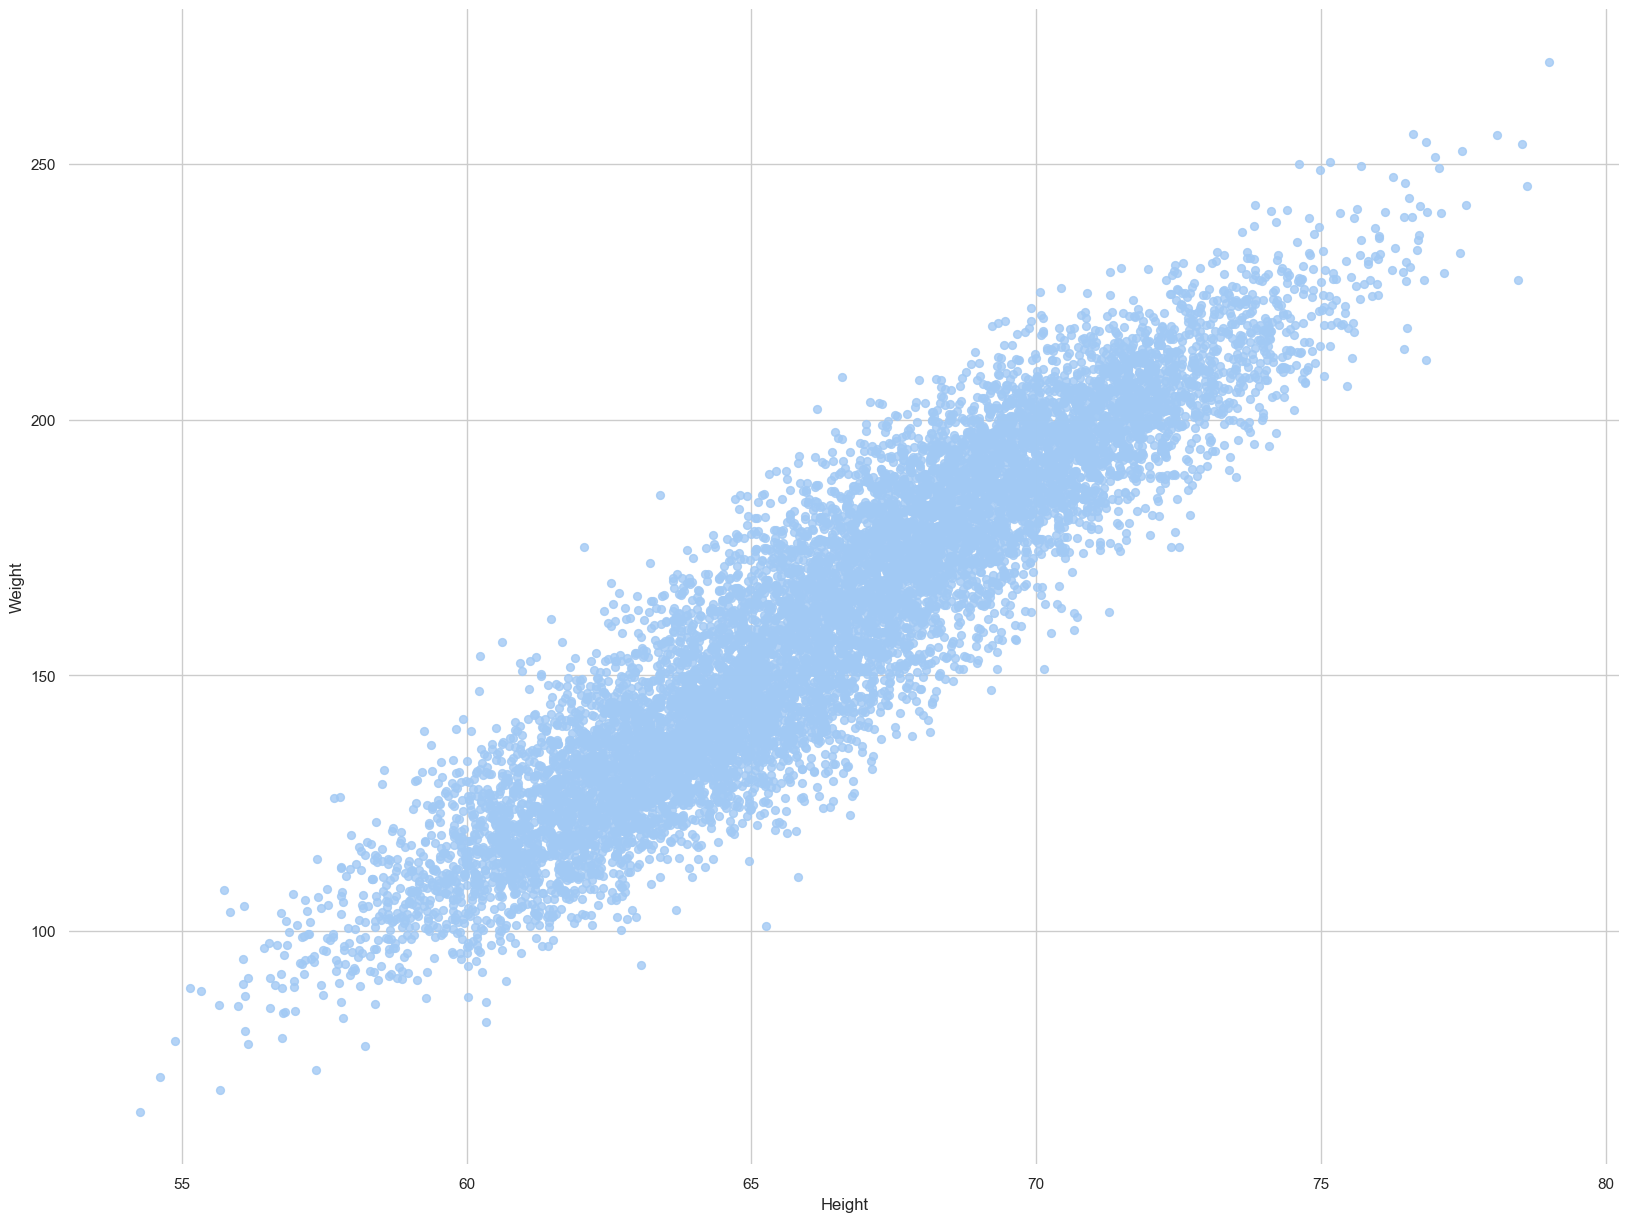

In [20]:
df.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Задание 1

## Решение

In [21]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.edgecolor'] = 'none'

In [22]:
def plot_with_anomalies(data, title, anomalies_index):
    plt.scatter(data.loc[~data.index.isin(anomalies_index), 'Height'],
                data.loc[~data.index.isin(anomalies_index), 'Weight'],
                c='green', label='Normal', alpha=0.8)
    plt.scatter(data.loc[data.index.isin(anomalies_index), 'Height'],
                data.loc[data.index.isin(anomalies_index), 'Weight'],
                c='red', label='Anomaly', alpha=0.8)
    plt.title(title)
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend()

In [23]:
# Подготовка данных
X = df[['Height', 'Weight']]

# 1. IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
anomalies_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)

In [24]:
iso = IsolationForest(contamination=0.01)
yhat_iso = iso.fit_predict(X)
anomalies_iso = yhat_iso == -1

In [26]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
yhat_lof = lof.fit_predict(X)
anomalies_lof = yhat_lof == -1

In [27]:
svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
yhat_svm = svm.fit_predict(X)
anomalies_svm = yhat_svm == -1

In [33]:
gm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gm.fit(X)
scores_gm = gm.score_samples(X)
threshold_gm = np.quantile(scores_gm, 0.01)
anomalies_gm = scores_gm < threshold_gm

In [36]:
dbscan = DBSCAN(eps=3, min_samples=5)
yhat_dbscan = dbscan.fit_predict(X)
anomalies_dbscan = yhat_dbscan == -1

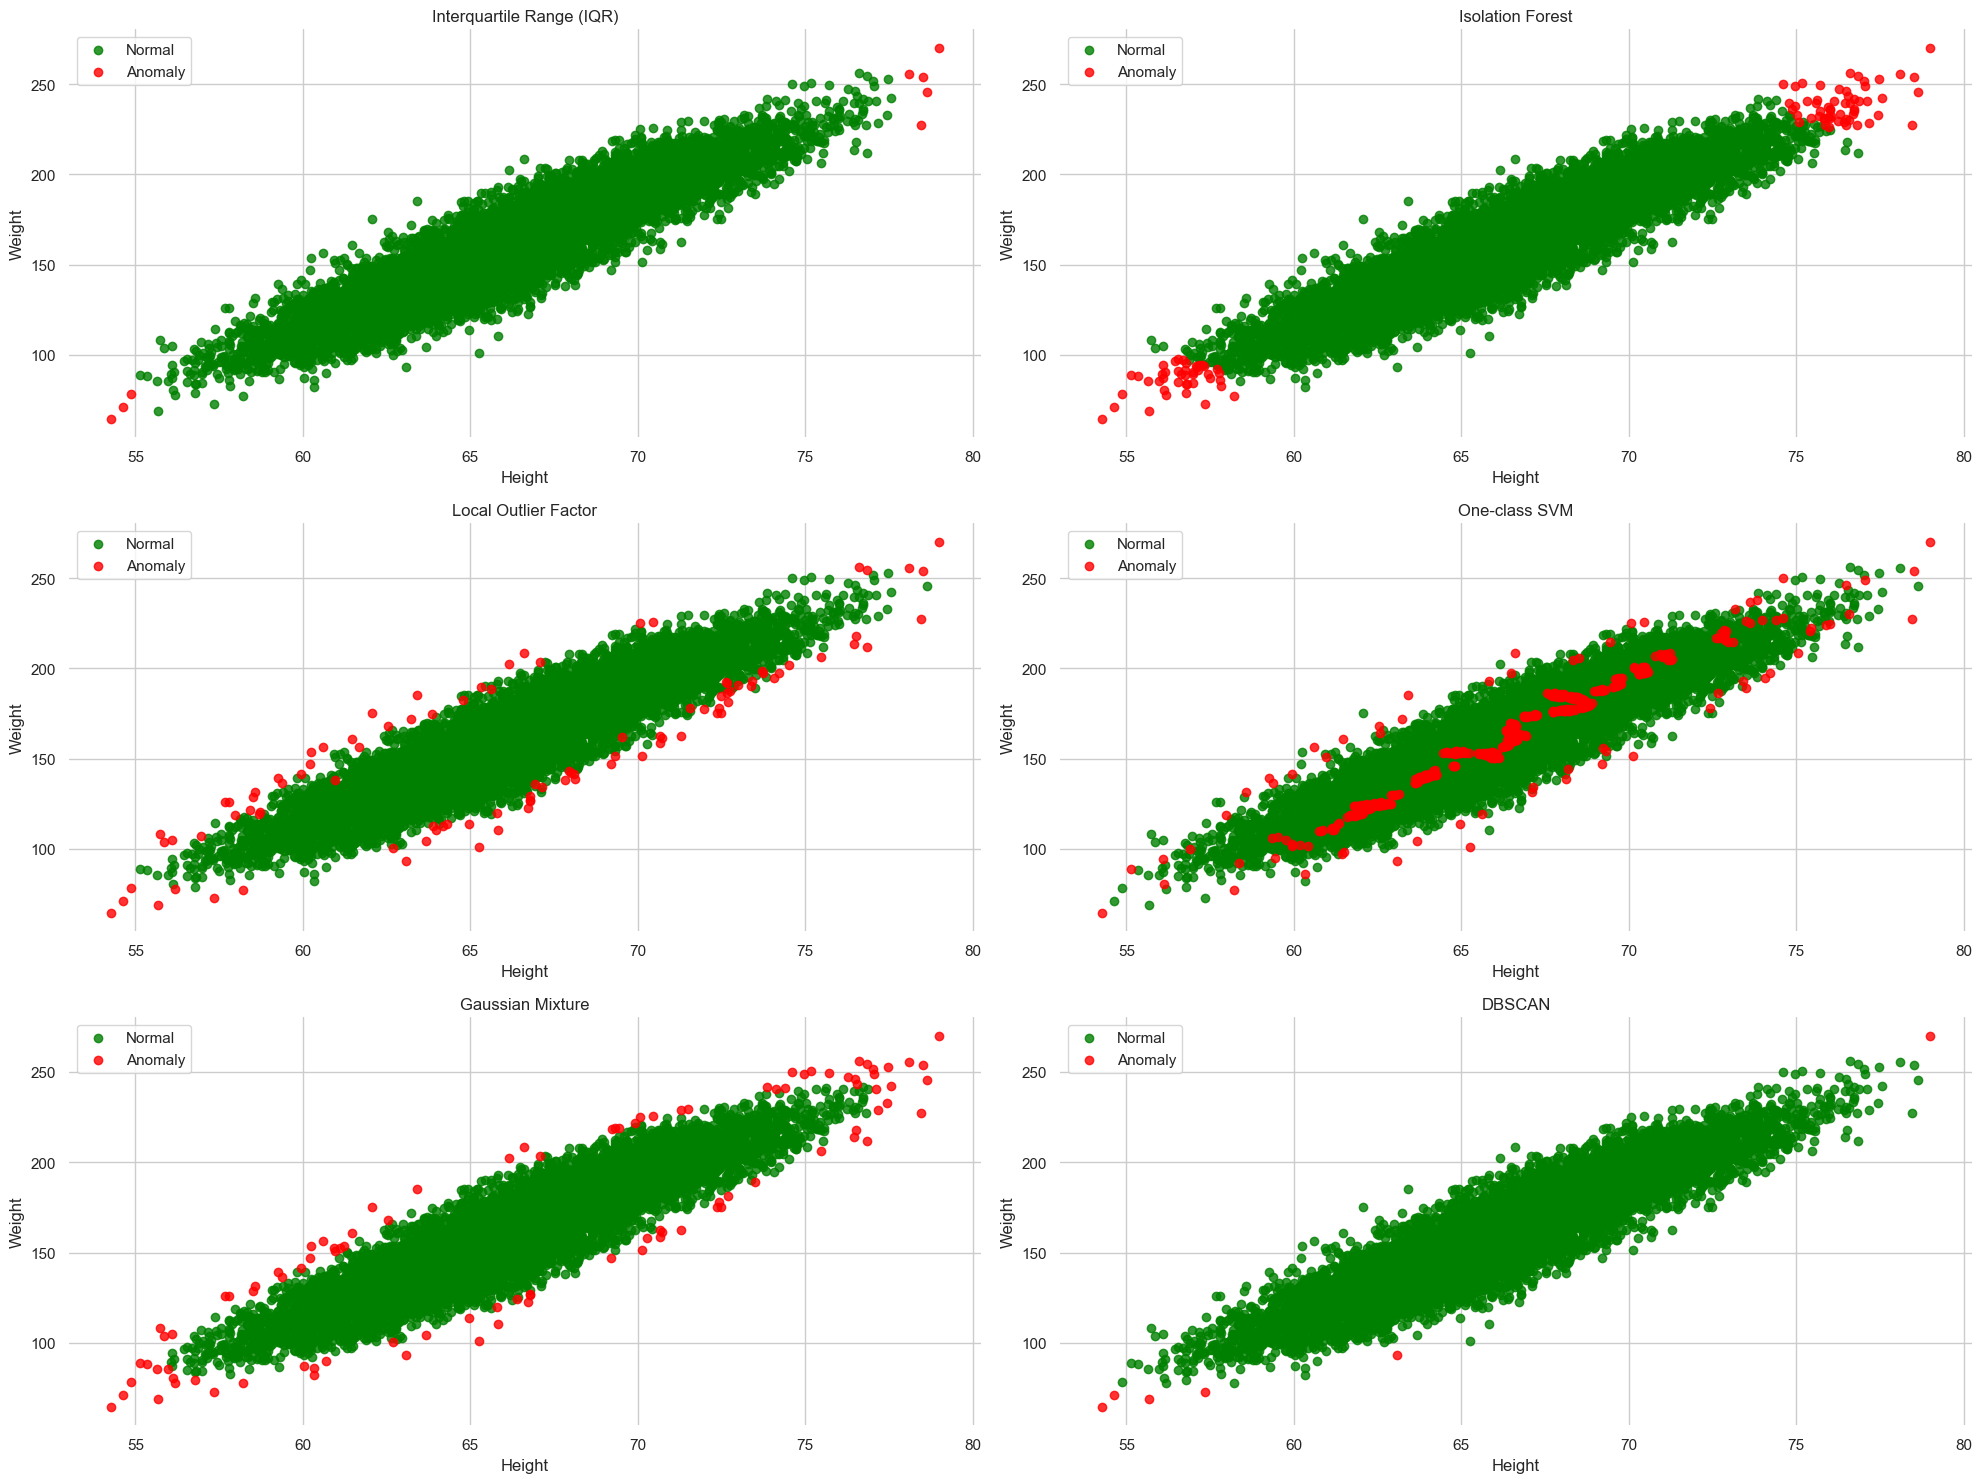

In [37]:
# Визуализация
fig, axs = plt.subplots(3, 2)

plt.subplot(3, 2, 1)
plot_with_anomalies(df, 'Interquartile Range (IQR)', anomalies_iqr[anomalies_iqr].index)

plt.subplot(3, 2, 2)
plot_with_anomalies(df, 'Isolation Forest', df[anomalies_iso].index)

plt.subplot(3, 2, 3)
plot_with_anomalies(df, 'Local Outlier Factor', df[anomalies_lof].index)

plt.subplot(3, 2, 4)
plot_with_anomalies(df, 'One-class SVM', df[anomalies_svm].index)

plt.subplot(3, 2, 5)
plot_with_anomalies(df, 'Gaussian Mixture', df[anomalies_gm].index)

plt.subplot(3, 2, 6)
plot_with_anomalies(df, 'DBSCAN', df[anomalies_dbscan].index)

plt.tight_layout()
plt.show()

## ВЫВОДЫ

**Interquartile Range (IQR)**: <br>Аномалии определены на основе межквартильного размаха. Этот метод эффективен для выявления экстремальных значений, но может не учитывать более сложные формы аномалий.<br>
**Isolation Forest:** Метод основан на изоляции аномалий, и его результаты показывают хорошую способность выделять аномальные данные, которые отличаются от большинства наблюдений.<br>
**Local Outlier Factor (LOF):** Алгоритм, основанный на плотности, показывает, как данные отличаются по плотности от их соседей. Это хорошо подходит для выявления локальных аномалий.<br>
**One-class SVM:** Этот метод ориентирован на поиск границы нормальных данных, выявляя то, что лежит за пределами этой границы, как аномальное.<br>
**Gaussian Mixture**: Модель, использующая смеси гауссовых распределений для моделирования данных, может выявить аномалии, основываясь на вероятностной мере принадлежности к компонентам смеси.<br>
**DBSCAN**: Алгоритм, основанный на плотности, идентифицирует кластеры и выделяет в качестве аномалий те точки, которые не принадлежат ни одному кластеру.

Лучше всего себя показали **Isolation Forest и Local Outlier Factor**, поскольку эти методы способны эффективно выявлять аномалии с учетом структуры данных. **Isolation Forest** быстр и эффективен для выявления аномалий в больших наборах данных, тогда как LOF предоставляет хорошую локализацию аномалий за счет сравнения плотности точек с их соседями. Эти методы показывают баланс между обнаружением глобальных и локальных аномалий в данных о росте и весе

# Задание 2

`IsolationForest` — метод обучение без учителя, видимо, опечатка, при составлении, но, тем не менее код выполнился

In [38]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [40]:
X = thyroid.drop(columns=['Outlier_label '])

In [41]:
params = {
    'n_estimators': list(range(5, 15)),
    'max_features': list(range(2, 10))
}

In [44]:
iso_forest = IsolationForest()
grid_search = GridSearchCV(estimator=iso_forest, param_grid=params, scoring='accuracy', cv=3, n_jobs=-1)

In [45]:
grid_search.fit(X)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
             scoring='accuracy')

In [46]:
best_params = grid_search.best_params_
best_params

{'max_features': 2, 'n_estimators': 5}

# Задание 3

Как я понял, случилась опечатка, имелся ввиду параметр не `n_jobs`, а `n_estimators`. Выполнил задание для параметров `n_estimators` 

In [65]:
# Заменим 'o' на 1 (аномалия), а 'n' на 0 (нормальное наблюдение)
y_true_binary = label_binarize(thyroid['Outlier_label '].values, classes=['n', 'o']).ravel()

In [66]:
n_estimators_range = [10, 50, 100, 150, 200, 250]

In [67]:
# Метрики и значения для построения ROC-кривых
f1_scores = []
precisions = []
recalls = []
roc_auc_scores = []
roc_curves = []

In [68]:
for n_estimators in n_estimators_range:
    iso_forest = IsolationForest(n_estimators=n_estimators, random_state=42)
    iso_forest.fit(X)
    y_pred = iso_forest.predict(X)

    # Преобразование предсказаний в бинарный формат (1 - аномалия, 0 - нормальное)
    y_pred_binary = (y_pred == -1).astype(int)

    # Расчет метрик
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_binary, y_pred_binary, average='binary')
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)
    roc_auc = auc(fpr, tpr)

    # Сохранение значений для визуализации
    f1_scores.append(f1_score)
    precisions.append(precision)
    recalls.append(recall)
    roc_auc_scores.append(roc_auc)
    roc_curves.append((fpr, tpr))

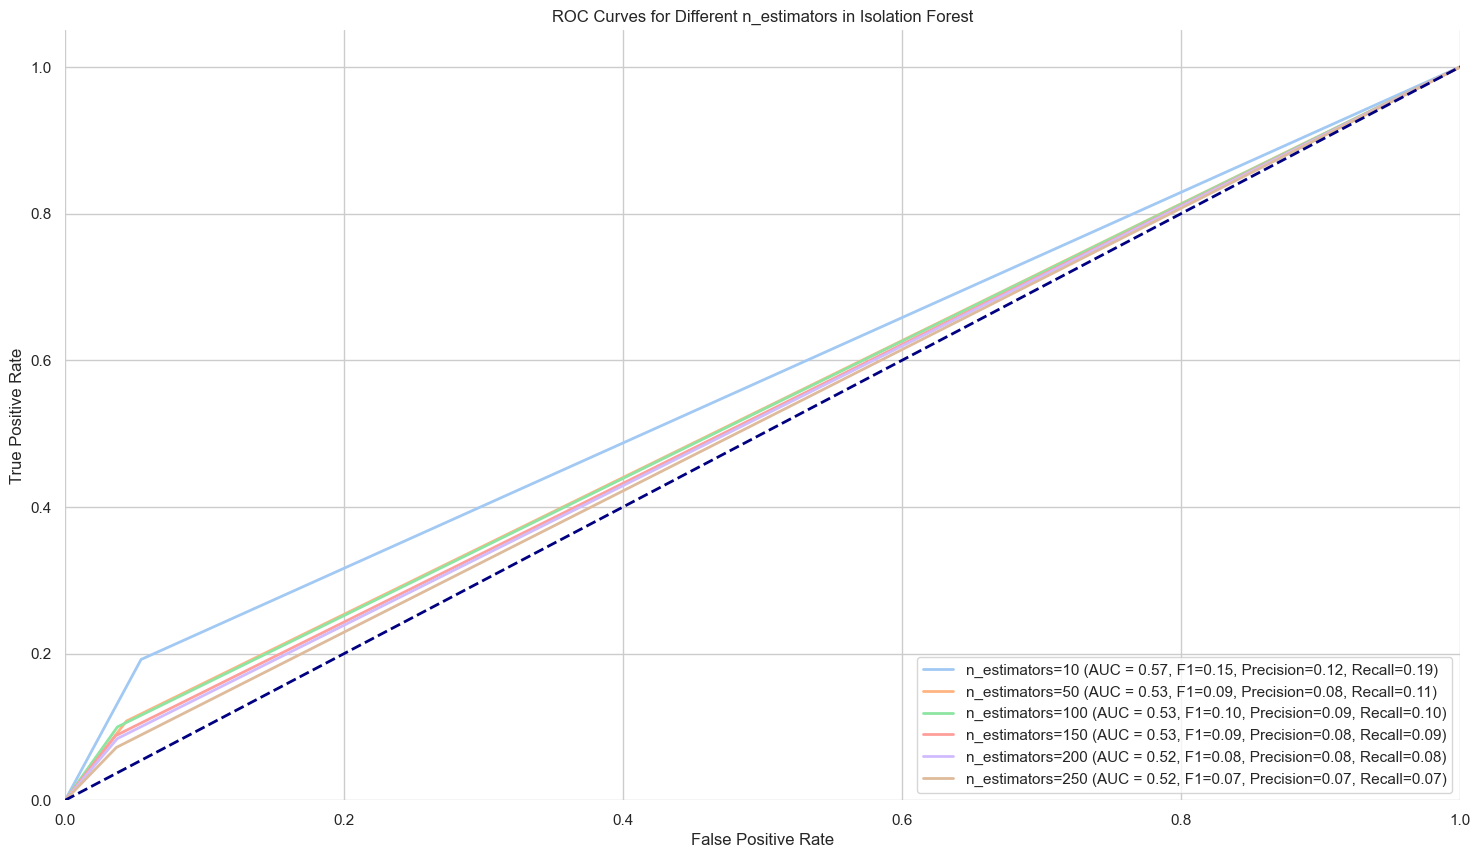

In [69]:
# Визуализация ROC-кривых
plt.figure(figsize=(18, 10))

for i, (fpr, tpr) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label='n_estimators=%d (AUC = %0.2f, F1=%0.2f, Precision=%0.2f, Recall=%0.2f)' % (
        n_estimators_range[i], roc_auc_scores[i], f1_scores[i], precisions[i], recalls[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different n_estimators in Isolation Forest')
plt.legend(loc="lower right")
plt.show()

# Задание 4

In [71]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


In [73]:
X = placement[['cgpa', 'placement_exam_marks']]
y = placement['placed']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


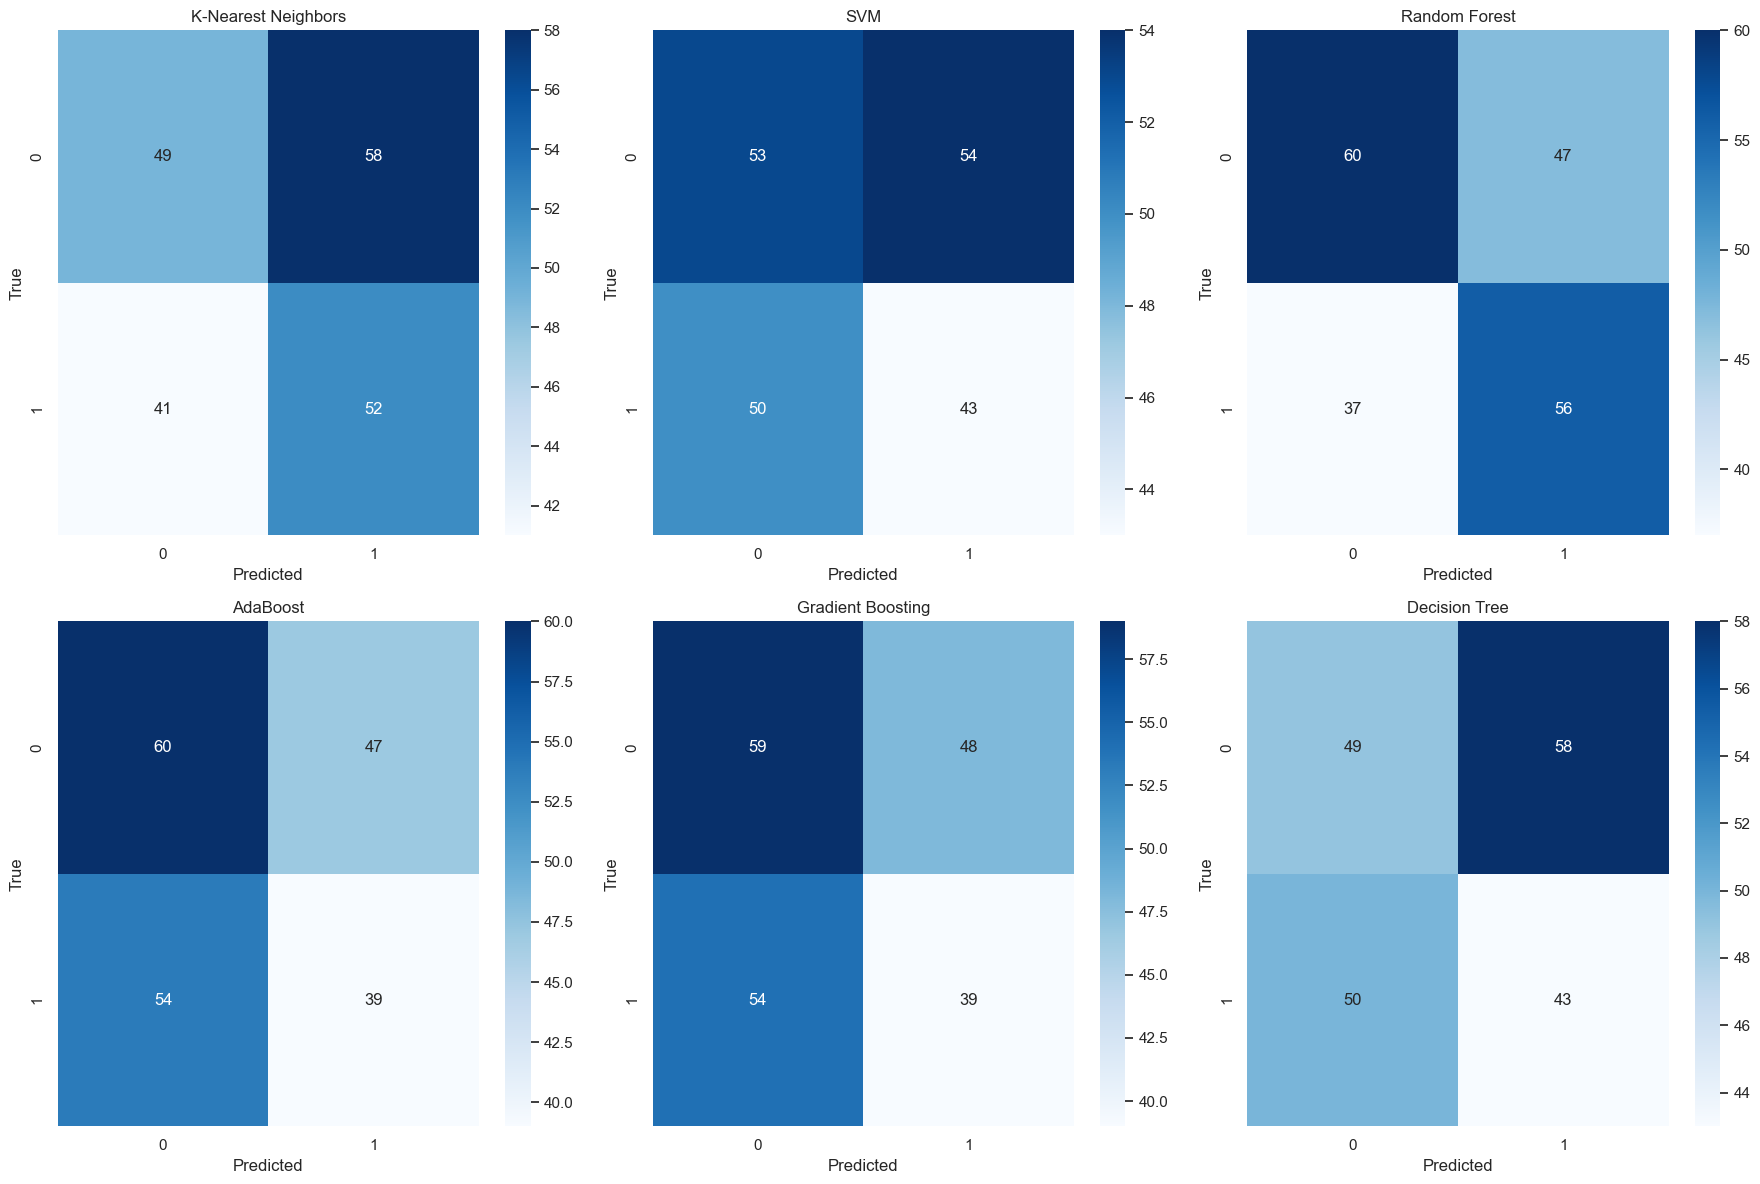

In [79]:
# Обучение моделей и создание confusion matrix для каждой модели
plt.figure(figsize=(18, 12))

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()